In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
from sklearn import neural_network
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import decomposition

# Data selection
The dataset is filtered by the classes *metal*$ \cup$*punk* and *dance and electronica*, assigning 1 and 0 as their respective labels.

In [2]:
data = pd.read_csv('msd_genre_dataset.txt',header=9)
dataf = data[(data['%genre']=='metal') | (data['%genre']=='punk') | (data['%genre']=='dance and electronica')]
dataf = dataf.replace(to_replace='punk', value=True)
dataf = dataf.replace(to_replace='metal', value=True)
dataf = dataf.replace(to_replace='dance and electronica', value=False)
data.head()

,%genre,track_id,artist_name,title,loudness,tempo,time_signature,key,mode,duration,...,var_timbre3,var_timbre4,var_timbre5,var_timbre6,var_timbre7,var_timbre8,var_timbre9,var_timbre10,var_timbre11,var_timbre12
0,classic pop and rock,TRFCOOU128F427AEC0,Blue Oyster Cult,Mes Dames Sarat,-8.697,155.007,1,9,1,246.33424,...,1255.514569,580.030472,598.485223,575.337671,322.068603,321.726029,232.700609,186.805303,181.938688,151.508011
1,classic pop and rock,TRNJTPB128F427AE9F,Blue Oyster Cult,Screams,-10.659,148.462,1,4,0,189.80526,...,2007.653070,1043.474073,585.694981,564.013736,510.177022,400.200186,365.119588,238.099708,197.933757,251.577525
2,classic pop and rock,TRLFJHA128F427AEEA,Blue Oyster Cult,Dance The Night Away,-13.494,112.909,1,10,0,158.19710,...,1204.856777,2736.520024,730.233239,665.203452,535.775111,439.335059,486.822970,265.333860,447.097987,251.880724
3,classic pop and rock,TRCQZAG128F427DB97,Blue Oyster Cult,Debbie Denise,-12.786,117.429,4,7,1,250.22649,...,809.755802,563.908070,492.803819,378.382799,372.875044,231.941957,246.313305,168.400152,85.282462,339.897173
4,classic pop and rock,TRNXMNM128F427DB8C,Blue Oyster Cult,(Don't Fear) The Reaper,-14.093,141.536,4,9,0,307.06893,...,1093.684935,343.556047,889.163314,218.111796,304.862864,178.352161,440.478867,142.669283,81.061326,208.355152


# Features
It is easy to see that there are 30 quantitative features to in the dataset, so these are the ones used for the analysis.

In [3]:
X = dataf[dataf.keys()[4:]]
Y = dataf['%genre']

# The approach
A two-hidden layer perceptron will be used, and it will be trained using the whole standardised dataset to allow for a simple implementation of stochastic gradient descent in accordance to the methods learned in class.

The number of neurons used in each layer will be adjusted sequentially on a grid to determine the optimal number of neurons for each layer, for different activation functions, such as the logistic sigmoid function and the hyperbolic tangent.

# Logistic sigmoid function
The logistic sigmoid function is fairly common for classification problems. The performance for the increasing numbers of neurons will be evaluated, by using different error criterions such as accuracy of the classifier on the training and testing datasets and cross validation.

# Plain old accuracy
In this case, the accuracy is estimated on a training dataset and a validation dataset. For a big enough amount of testing data, the estimated real error is close to its true value, however, choosing the best classifier based on this criterion, makes said classifier dependent on the testing data.

In [4]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.2)
scaler=preprocessing.StandardScaler().fit(X_train)
X_trains=scaler.transform(X_train)
X_tests=scaler.transform(X_test)
scores_train = np.zeros((25, 25))
scores_test = np.zeros((25,25))
for i in range(4,104,4):
    for j in range(4,104,4):
        neurc = neural_network.MLPClassifier(hidden_layer_sizes=(i,j,), activation='logistic', solver='sgd', max_iter=1000)
        neurc.fit(X_trains, Y_train)
        scores_train[int(i/4-1),int(j/4-1)] = neurc.score(X_trains, Y_train)
        scores_test[int(i/4-1),int(j/4-1)] = neurc.score(X_tests, Y_test)

### Note:
The number of neurons increases downwards, and from left to right on the presented plots, varying between 4 and 100.

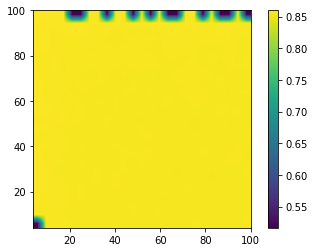

In [5]:
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import axes3d
plt.imshow(scores_train, interpolation='bilinear', extent=[4,100,4,100])
plt.colorbar()

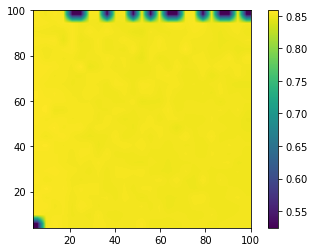

In [6]:
plt.imshow(scores_test, interpolation='bilinear', extent=[4,100,4,100])
plt.colorbar()

There is no clear tendency that shows a combination being better than the others, so cross-validation will be used instead.

# Cross validation
It is thought that in certain cases it offers a better approach to the real classification error by reducing the variance, however one problem that it presents is that the estimated errors used to compute the averafe error, are not independent so the resulted average may have a different meaning., and it is not so easy to find a bound in this case.

In order to ensure that the classifier does not depend on the data a testing set of 2048 samples will be reserved and won't be used during the exploration to find the optimal number of neurons.

For cross validation the training data will be split randomly in 10 bins and one of them will be seclected to compute a total of 10 errors per iteration which will be averaged to give the score.

In [7]:
scores = np.zeros((25,25))
for i in range(4,104,4):
    for j in range(4,104,4):
        neurc = neural_network.MLPClassifier(hidden_layer_sizes=(i,j,), activation='logistic', solver='sgd', max_iter=1000)
        scores[int(i/4-1),int(j/4-1)] = np.mean(np.array(model_selection.cross_val_score(neurc, X_train, Y_train, cv=10, n_jobs=-1)))

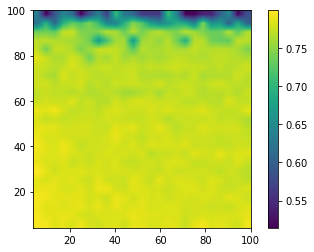

In [8]:
plt.imshow(scores, interpolation='bilinear', extent=[4,100,4,100])
plt.colorbar()

In this case there is a clear tendency that shows that a greater number of neurons per layer yields a higher accuracy, with the best classifier being the one with 100 neurons per layer, having an accuracy of:

In [9]:
neurc = neural_network.MLPClassifier(hidden_layer_sizes=(100,100,), activation='logistic', solver='sgd', max_iter=1000)
neurc.fit(X_trains, Y_train)
print('The mean accuracy on the training samples is: %f' %(neurc.score(X_trains, Y_train)))
print('The mean accuracy on the testing samples is: %f' %(neurc.score(X_tests, Y_test)))

The mean accuracy on the training samples is: 0.855189
The mean accuracy on the testing samples is: 0.850098


Which is pretty much the same as the one found with logistic regression, but with less overfitting.

# Hyperbolic tangent
It has already been established that the cross-validation error is a better criterion to determine the performance of the percetron, across different numbers of neuron, so this criterion will be used from now on.

In [10]:
scoresh = np.zeros((25,25))
for i in range(4,104,4):
    for j in range(4,104,4):
        neurc = neural_network.MLPClassifier(hidden_layer_sizes=(i,j,), activation='tanh', solver='sgd', max_iter=1000)
        scoresh[int(i/4-1),int(j/4-1)] = np.mean(np.array(model_selection.cross_val_score(neurc, X_train, Y_train, cv=10,n_jobs=-1)))

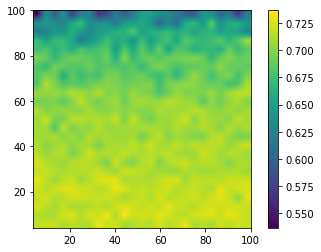

In [11]:
plt.imshow(scoresh, interpolation='bilinear', extent=[4,100,4,100])
plt.colorbar()

Which points to a a better performance with a greater number of neurons per layer, without being significantly better than the one found with logistic regression. With the best accuracy being:

In [12]:
neurc = neural_network.MLPClassifier(hidden_layer_sizes=(100,100,), activation='tanh', solver='sgd', max_iter=1000)
neurc.fit(X_trains, Y_train)
print('The mean accuracy on the training samples is: %f' %(neurc.score(X_trains, Y_train)))
print('The mean accuracy on the testing samples is: %f' %(neurc.score(X_tests, Y_test)))

The mean accuracy on the training samples is: 0.911355
The mean accuracy on the testing samples is: 0.884277


# The rectified linear function
This is the function used by default in SKlearn for this kind of problems, and is simply the ramp function yielding the results:

In [13]:
scoresr = np.zeros((25,25))
for i in range(4,104,4):
    for j in range(4,104,4):
        neurc = neural_network.MLPClassifier(hidden_layer_sizes=(i,j,), solver='sgd', max_iter=1000)
        scoresr[int(i/4-1),int(j/4-1)] = np.mean(np.array(model_selection.cross_val_score(neurc, X_train, Y_train, cv=10, n_jobs=-1)))

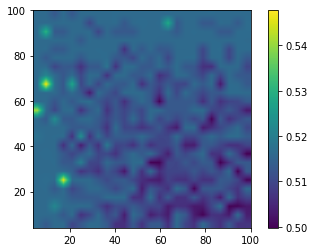

In [14]:
plt.imshow(scoresr, interpolation='bilinear', extent=[4,100,4,100])
plt.colorbar()

The activation function in this case is less complex, but there seems to be a big compromise in terms of accuracy. There is no clear tendency and the accuracy seems to be significantly worse.

In the case of 200 neurons, the accuracy on the training and testing dataset take a value of:

In [15]:
neurc = neural_network.MLPClassifier(hidden_layer_sizes=(100,100,), solver='sgd', max_iter=1000)
neurc.fit(X_trains, Y_train)
print('The mean accuracy on the training samples is: %f' %(neurc.score(X_trains, Y_train)))
print('The mean accuracy on the testing samples is: %f' %(neurc.score(X_tests, Y_test)))

The mean accuracy on the training samples is: 0.970452
The mean accuracy on the testing samples is: 0.879395


In this case, it is worth it to take a second look to these accuracies along different numbers of neurons, as the amount training samples might be too little for cross-validation, and the fit seems to be good for the case with 100 neurons per layer, although with a higher overfitting than the rest of the methods.

In [16]:
scores_trainr = np.zeros((25, 25))
scores_testr = np.zeros((25,25))
for i in range(4,104,4):
    for j in range(4,104,4):
        neurc = neural_network.MLPClassifier(hidden_layer_sizes=(i,j,), solver='sgd', max_iter=1000)
        neurc.fit(X_trains, Y_train)
        scores_trainr[int(i/4-1),int(j/4-1)] = neurc.score(X_trains, Y_train)
        scores_testr[int(j/4-1),int(j/4-1)] = neurc.score(X_tests, Y_test)

/home/juan/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


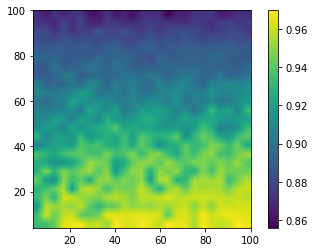

In [17]:
import matplotlib.pyplot as plt
plt.imshow(scores_trainr, interpolation='bilinear', extent=[4,100,4,100])
plt.colorbar()

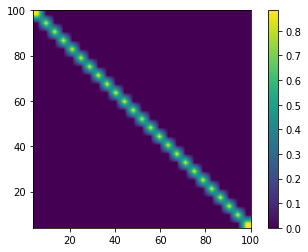

In [18]:
plt.imshow(scores_testr, interpolation='bilinear', extent=[4,100,4,100])
plt.colorbar()

# Analysis
A brief summary for the best accuracy found for the different methods is presented:

|Method|Sigmoid logistic function|Hyperbolic tangent|Rectified linear function|
|------|--------|--------|---|
|   Accuracy on testing set  |   0.8532  |      0.8593     | 0.8968 |
|  Accuracy on training set  |   0.8618  |      0.8667     | 0.8828 |

Using Chernoff's absolute error bounds it is possible to say, with a confidence of 95%, that:

$\epsilon=\sqrt{\frac{1}{2*2048}\frac{1}{\ln(\frac{1}{0.025})}}\approx 0.03$

Which means that with the current size of our testing batch (2048), it is possible to say that with a probability of 95%, our estimator for the real accuracy of the classifier does not differ in more than 3%.

# Conclussions
Accorrding to the found accuracies and the Chernoff bound, it is possible to say that the rectified linear function classifier with 200 neurons is significantly better than the other classifiers.

Given the amount of testing samples it is possible to say that our estimator for the real accuracy does not differ from the real accuracy in more than 3% with a confidence of 95%.

The number of testing samples and variability of the estimators with respect to the real value should be taken into account when choosing an adecuate error criterion.